# Let's Code - Santander Coders (turma 806)
## Módulo 4 - Machine Learning
### Exercício Titanic por Samya de Lara Pinheiro - Árvore de Decisão
Crie uma arvore de decisão para os dados do Titanic, avaliando se os passageiros vão sobreviver ou não. (Cuidado com a idade em anos/meses).  
Para pegar os dados, use: https://www.kaggle.com/c/titanic/data  
Proponha uma otimização dos hiperparâmetros max_depth e min_samples_leaf e avalie os resultados

In [65]:
# importanto pacotes 
import pandas as pd
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# ler arquivo de treino
# dados recuperados do site do projeto no Kaggle - https://www.kaggle.com/c/titanic/data 
url_dados = 'https://raw.githubusercontent.com/samyadelara/letscode_course/main/Module4/Ex_Titanic/train.csv'
titanic = pd.read_csv(url_dados)

#### EDA

Como o intuito do exercício é desenvolver modelo que classifique se o passageiro sobreviveu ou não, serão excluída features que identificam os passageiros (como *PassengerId*, *Name*, *Ticket*, *Cabin*) e possuem pouco potencial em caracterizar grupos de passageiros. Após esta limpeza será feita uma análise exploratória básica, para verificar a existência de potenciais outliers, análise preliminar das potenciais associações entre variáveis e padrões de variabilidade para as classes Sobrevivente/Não_Sobrevivente. 

In [55]:
# limpeza (drop) de features identificadoras
df = titanic.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Text(0.5, 1.0, 'Survived counts in Titanic dataset')

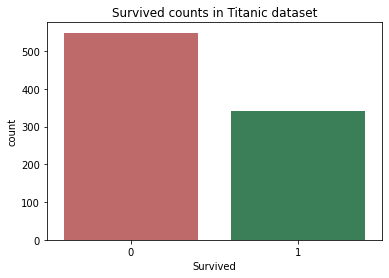

In [14]:
#cores padrão p/ classes Sobrevivente/Não_Sobrevivente
cores = ["indianred", "seagreen"]

# histograma geral
sns.countplot(x=df['Survived'], palette = cores).set_title('Survived counts in Titanic dataset')

Text(0.5, 0.98, 'Boxplot - quantitative features \n Titanic dataset')

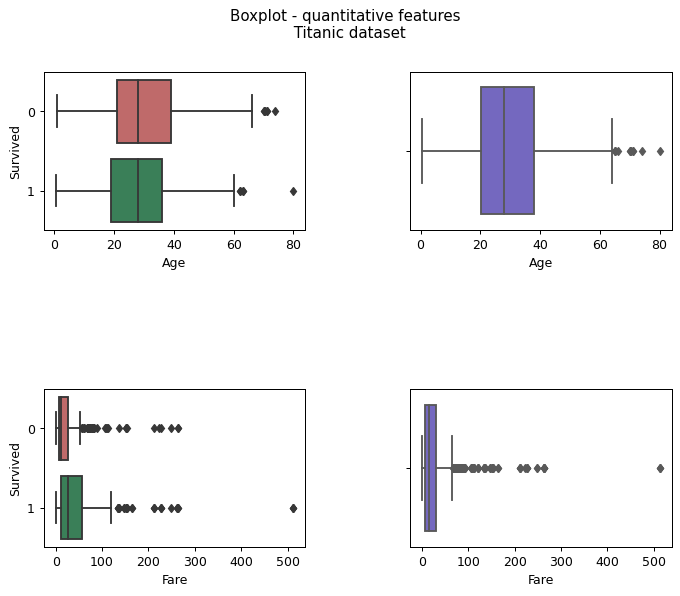

In [19]:
# box plots para variáveis quantitativas
num_var = ['Age', 'Fare']
fig = plt.figure(figsize=(9, 7), dpi= 90)
fig.subplots_adjust(hspace=1, wspace=0.4)
for i in range(0,2):
    ax = fig.add_subplot(2, 2, i*2+1)
    sns.boxplot(x=df[num_var[i]], y=df['Survived'].astype('category'), ax = ax, palette = cores)
    ax = fig.add_subplot(2, 2, i*2+2)
    sns.boxplot(x=df[num_var[i]], ax = ax, color = 'slateblue')
fig.suptitle('Boxplot - quantitative features \n Titanic dataset')

Text(0.5, 0.98, 'Histogram - qualitative features \n Titanic dataset')

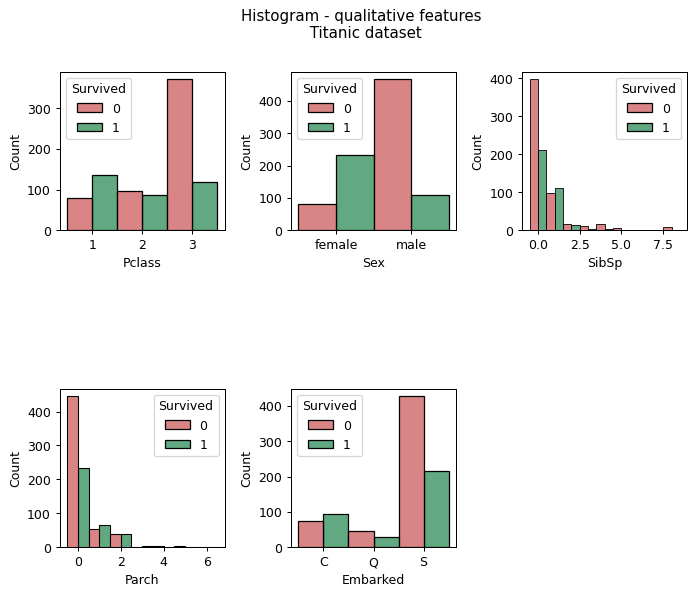

In [33]:
# histogramas para variáveis qualitativas
cat_var = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
fig = plt.figure(figsize=(9, 7), dpi= 90)
fig.subplots_adjust(hspace=1, wspace=0.4)
for i in range(0,5):
    ax = fig.add_subplot(2, 3, i+1)
    sns.histplot(x=df[cat_var[i]].astype('category'), hue=df['Survived'].astype('category'), multiple="dodge", palette=cores, ax = ax)
fig.suptitle('Histogram - qualitative features \n Titanic dataset')

A não-sobrevivência aparenta ser característica prevalente em grupo:
- pessoas menos jovens (SALVEM as CRIANÇAS!!!)
- que pagou menores tarifas (indicando potencial associação com status socioecoômico)
- da classe 3
- de homens
- que embarcaram em Southampton

#### Tratamento dos dados  
A base apresenta alguns dados faltantes que devem ser tratados antes do processo de modelagem. O relatório de `df.info` indica que a variável idade apresenta maior frequência de dados faltantes. Em acidentes como o do Titanic, é conhecida a priorização de mulheres, idosos e crianças na evacuação e ações de salvamento. Assim, o tratamento da variável idade com inserção de valor médio, moda ou outra estratégia, definitivamente irá enviezar a modelagem. Como o enfoque do exercício não era avaliar o impacto destas estratégias, optou-se pela exclusão dos registros (`dropna`) que contém valores faltantes. A base foi reduzida de 891 registros para 712 (redução de 20%).  

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [56]:
# drop dados faltantes
df = df.dropna()

Após a limpeza, é feita a preparação da base para a aplicação do algoritmo de árvore de decisão. A implementação utilizada neste exercício só aceita dados numéricos. Assim, foram definidos códigos para as variáveis categóricas nominais: *Sex* codificada com *Sex_male* = 1 (homem) ou 0 (mulher) e *Embarked* com `label encoder`.

In [57]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [58]:
# codificando variáveis categóricas/qualitativas nominais

le = preprocessing.LabelEncoder()
tmp = le.fit_transform(df['Embarked'])
df['Embarked'] = tmp

male = pd.get_dummies(df['Sex'], prefix='sex', drop_first = True)
df = pd.concat([df, male], axis=1)
df = df.drop(columns='Sex')
df.head()
    

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,sex_male
0,0,3,22.0,1,0,7.2500,2,1
1,1,1,38.0,1,0,71.2833,0,0
2,1,3,26.0,0,0,7.9250,2,0
3,1,1,35.0,1,0,53.1000,2,0
4,0,3,35.0,0,0,8.0500,2,1


O algoritmo de árvore de decisão é menos sensível à dimensão das features. Logo, não é impactado pela amplitude de variáveis e não exige a padronização para a modelagem.

#### Definição de amostra Treino/Teste
O foco do exercício é a prática de técnicas de otimização de hiperparâmetros. Não serão exploradas técnicas diferenciadas de amostragem e particionaremos a base em **TREINO** (70%) e **VALIDAÇÃO** (30%) - HoldOut. Apenas na otimização de hiperparâmetros, será feita validação cruzada com base no método Kfold. Reportaremos a análise de resultados baseada na performance na amostra de validação.

In [59]:
# particionando a base de dados
from sklearn.model_selection import train_test_split 
X = df.drop(['Survived'], axis = 1)
y = df['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(X,y,
test_size=0.3,
random_state=42,
stratify=y)

#### Modelagem  
- Modelo baseline  
Pela análise do histograma inicial, sabemos que mais pessoas morreram do que sobreviveram no acidente. Assim, nosso modelo baseline irá considerar um classificador baseado na moda, prevendo todos os casos como não sobreviventes (modelo trágico).

> F1-score weighted = 0.44

In [62]:
# baseline = MODA
model = DummyClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       127
           1       0.00      0.00      0.00        87

    accuracy                           0.59       214
   macro avg       0.30      0.50      0.37       214
weighted avg       0.35      0.59      0.44       214



c:\Users\sllap\OneDrive\Documents\DataScience\Cursos avulsos\LetsCode_Santander\Aulas_Coders\Modulo4_DS\modulo04-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sllap\OneDrive\Documents\DataScience\Cursos avulsos\LetsCode_Santander\Aulas_Coders\Modulo4_DS\modulo04-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sllap\OneDrive\Documents\DataScience\Cursos avulsos\LetsCode_Santander\Aulas_Coders\Modulo4_DS\modulo04-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

Vamos agora propor modelos baseados no algoritmo de Árvore de Decisão. Inicialmente, façamos a árvore com base na configuração default da implementação do `sklearn`.  
  
- Árvore 0  
> F1-score weighted = 0.70

In [63]:
# árvore 0
model = DecisionTreeClassifier(random_state=42)
arv0 = model.get_params() #guarde esse parametro
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       127
           1       0.63      0.61      0.62        87

    accuracy                           0.70       214
   macro avg       0.68      0.68      0.68       214
weighted avg       0.69      0.70      0.70       214



In [64]:
arv0

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Ao avaliar os hiperparâmetros do modelo Árvore 0, percebemos que não há limites para a profundidade da árvore (*max_depth*). Adiante, faremos uma otimização de parâmetro com base em grid search aleatório (mais performático).

In [66]:
# definindo espaço do grid
espaco_hiperparametros ={
    'max_depth': randint(3, 15),
    'min_samples_leaf': randint(1, 50)
}

In [69]:
# rodando o modelo no grid
rand_search = RandomizedSearchCV(model, espaco_hiperparametros, cv=3, n_iter=50)
search = rand_search.fit(X, y)
rand_search.best_params_

{'max_depth': 6, 'min_samples_leaf': 4}

Nossa otimização com 50 iterações identificou a profunidade ótima de 6 e mínimo de amostras por folha de 4. Iremos então ajustar o modelo Árvore ótima na amostra de teste previamente definida e verificar sua performance no set de validação (para efeitos de comparação com os outros métodos).  
- Árvore Ótima  
> F1-score weighted = 0.80

In [70]:
# árvore ótima
model = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_leaf=4)
arvOtima = model.get_params() #guarde esse parametro
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       127
           1       0.84      0.64      0.73        87

    accuracy                           0.80       214
   macro avg       0.81      0.78      0.79       214
weighted avg       0.81      0.80      0.80       214



A otimização de hiperparâmetros é uma estratégia chave no ajuste de modelos de machine learning. As implementações de grid.search em `Python` são muito flexíveis e permitem que o cientista explore diversas combinações, convergindo para a configuração que maximiza os resultados de interesse.  
No exemplo explorado do exercício, foi possível melhorar a métrica de análise de performance do modelo de classificação escolhida, otimizando o ajuste do modelo tanto na classe de sobreviventes quanto não sobreviventes.